# Evaluation of an LSTM-AutoEncoder on the CERT Insider Threat Detection Dataset
# Kai Gomes, Zachary Lawton

Dependencies

In [88]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler


## Load Dataset

Loads CERT v6.2 email dataset

In [89]:
# df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\r6.2\\r6.2\\email.csv") #kai PC
df = pd.read_csv("D:\\r6.2\\email.csv") #zach pc
len(df)

10994957

Loads answers (malicious) for dataset and drops unecessary columns (all that aren't in email dataset)

In [90]:
# answers_df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\answers\\answers\\r6.2-3.csv", header=None) #kai pc
answers_df = pd.read_csv("D:\\answers\\r6.2-3.csv", header=None)
answers_df = answers_df.where(answers_df[0] == 'email')
answers_df = answers_df[answers_df[0].notna()]
answers_df = answers_df.rename(columns={1: 'id', 2: "date", 3: "user", 4: "pc", 5: "to", 6: "cc", 7:"bcc", 8:"from", 9:"activity", 10:"size", 11: "attachment", 13: "content" })
answers_df = answers_df.drop([0, 12], axis=1)

Labels email data with malicious column

In [91]:
malicious_ids = answers_df['user'].unique()
df['malicious'] = [1 if x in malicious_ids else 0 for x in df['user']]

## Undersample data

Picks percentage of malicious data wanted and then scales non-malicious down to equal percentage

In [92]:
num_non_mal = len(df.loc[df['malicious'] == 0])
num_mal = len(df.loc[df['malicious'] == 1])
percent_want_mal = 0.1
num_non_mal_sample = num_non_mal - int(num_non_mal - (num_non_mal - (num_mal / percent_want_mal - num_mal)))
sample = df.loc[df['malicious'] == 0].sample(n = num_non_mal_sample, random_state=42).index.tolist()
df = df.drop(sample, axis=0)

In [93]:
print(num_mal, len(df) - num_mal)

90600 815400


## Feature Extraction

Gets number of words in message from message content

In [94]:
df['num_words'] = [len(x.split()) for x in df['content']]

Gets number of destinations, number of external destinations, and number of external destinations that appear in bcc:

In [95]:
df['num_dest'] = df.apply(lambda x: len(re.findall("(@)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))), axis=1)

In [96]:
df['num_external'] = df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

In [97]:
df['num_external_bcc'] =  df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

Gets the number of attachments, total size of all attachments, number of different file types of attachments (.pdf, .doc, etc), and number of bcc recipients

In [98]:
df['num_attach'] = [len(x.split(";")) if type(x) == str else 0 for x in df['attachments']]

In [99]:
df['attach_size'] = [sum(map(int, re.findall("\(([^()]+)\)", x))) if type(x) == str else 0 for x in df['attachments']]

In [100]:
df['num_attach_type'] = [len(set(re.findall("\.(.*?)\(", x))) if type(x) == str else 0 for x in df['attachments']]

In [101]:
df['num_bcc'] = [len(x.split(";")) if type(x) == str else 0 for x in df['bcc']]

Creates a new dataframe with only the quantitative data that is able to be parsed

In [102]:
df = df[['date', 'num_dest','num_attach','num_attach_type', 'attach_size', 'num_external', 'num_external_bcc', 'size', 'num_words', 'num_bcc', 'malicious']]

Create y (malicious or not, not used in model itself since unsupervised)

In [103]:
y = df['malicious']
df = df.drop('malicious', axis=1)

## Normalize Data

Scale the features so that the model is more accurate (using `MinMaxScaler()`) and split into train/test data

In [104]:
dates = pd.to_datetime(df['date']).values
x = df.drop('date', axis=1).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
# df['date'] = dates

## Create and Run Models

Split Data into train and test data: 66% train and 33% test

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

### AutoEncoder

Creates model: encoder has 3 dense layers and 3 dropoout layers, repeat vector, and decoder has 3 dense layers and 3 dropoout layers

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 128)               1280      
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 32)                1056      
                                                                 
 dropout_30 (Dropout)        (None, 32)              

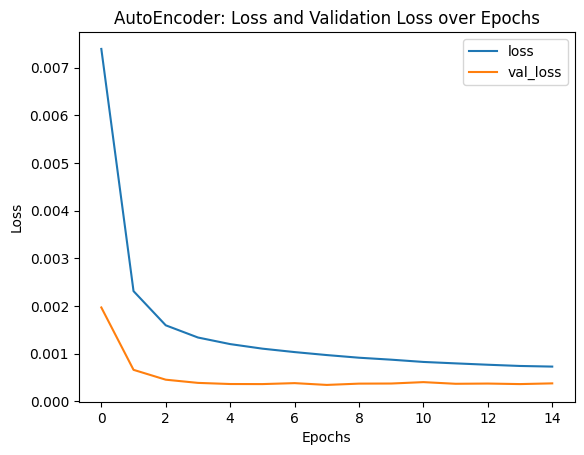

In [134]:
input_dim = X_train.shape[1] #num of predictor variables, 
encoding_dim = 2

# define model
model = Sequential()
model.add(Input(shape=(input_dim,)))
#encoder
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu' ))
# model.add(RepeatVector(input_dim))
#decoder
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(X_train.shape[1], activation='relu'))
model.compile(optimizer='adam', loss='mse')
model.summary()
model
# fit model
history = model.fit(X_train, X_train, epochs=15, batch_size=10000, validation_data=(X_test, X_test))
# plot_model(model, show_shapes=True)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("AutoEncoder: Loss and Validation Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Predicts the values using the testing data

In [135]:
yhat = model.predict(X_test, verbose=0)

Calculates the anomoly score for each input in the testing data by the difference of the sum of the features and the predicted y value. Then established the anomoly cutoff based on the percentage of malicious datapoints in our sample and plots a histogram. This usually is done experimentally, but since we know the percentage of malicious in our dataset, we are able to evaluate the perfomance of the model.

Threshold: 0.11901725890216376


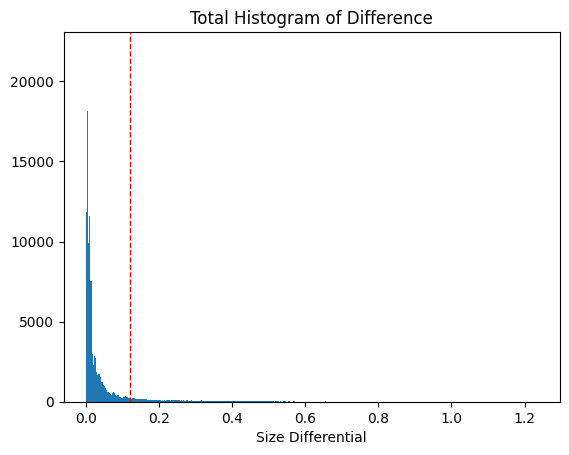

In [155]:
diff = [abs(x.sum() - y.sum()) for x, y in zip(X_test.to_numpy(), yhat)]
plot = plt.hist(diff, bins='auto')
plt.title("Total Histogram of Difference")
plt.xlabel("Size Differential")

i, total, percent = 0,0,0
while percent < .9:
    total+=plot[0][i]
    percent =  total / X_test.shape[0]
    i+=1
print("Threshold:", plot[1][i])
plt.axvline(plot[1][i], color='red', linestyle='dashed', linewidth=1)
plt.show()

Seperates the anomolies from the regular data using the threshold value

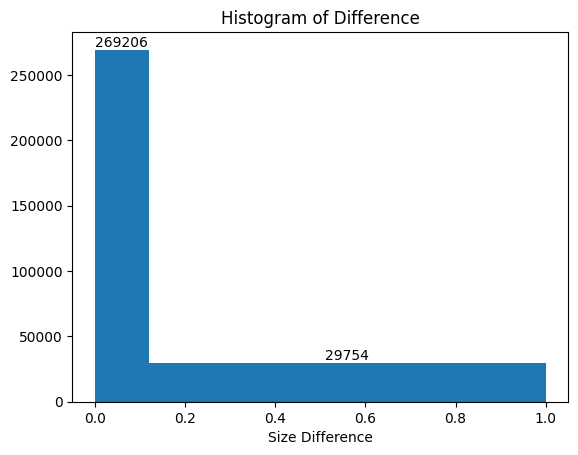

In [156]:
counts, edges, bars = plt.hist(diff,bins=[0,plot[1][i],1])
size_bar = plt.bar_label(bars)
plt.title("Histogram of Difference")
plt.xlabel("Size Difference")
plt.show()

### LSTM w/ timeseries

This creates timesteps that are 1 day apart. However, each day does not have an equal number of datapoints

In [ ]:
# def get_days(x, i, current_time):
#     start_day = current_time
#     while current_time == start_day and i < len(x):
#         current_time = x.iloc[i]['date']
#         i+=1
#     return i, current_time


# def to_sequences(x, y):
#     x_values = []
#     y_values = []
#     current_time = x['date'].iloc[0]
#     end_time = x['date'].iloc[-1]
#     j = 0
#     while current_time <= end_time:
#         step, next_day = get_days(x,j,current_time)
#         if step < len(x):
#             x_values.append(x.iloc[j:step].values)
#             y_values.append(y.iloc[step])            
#             current_time = next_day
#         else:
#             x_values.append(x.iloc[j:step-1].values)
#             y_values.append(y.iloc[step-1])
#             break   
#         j=step
#     return np.array(x_values), np.array(y_values)

Seperates into equal siaed timesteps

In [157]:
def to_sequences_homogenous(x, y, seq_size=1):
    x_values = [x.iloc[i:(i+seq_size)].values for i in range(len(x)-seq_size)]
    y_values = [y.iloc[i:i+seq_size] for i in range(len(x)-seq_size)]
        
    return np.array(x_values), np.array(y_values)

Pick timesteps and split into train and test

In [158]:
# xtrain, ytrain = to_sequences(df, df.drop('date', axis=1))
X_timeseries, y_timeseries = to_sequences_homogenous(df, df, 50)
X_train, X_test, y_train, y_test = train_test_split(X_timeseries, y_timeseries, test_size=0.33, random_state=42)

Creates model: encoder has 1 LSTM layer and dropoout layer, repeat vector, and decoder has 1 LSTM and dropout layer and then processes timeseries data with the TimeDistributed wrapper 

In [159]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               70656     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 10, 128)          0         
 or)                                                             
                                                                 
 lstm_17 (LSTM)              (None, 10, 128)           131584    
                                                                 
 dropout_33 (Dropout)        (None, 10, 128)           0         
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 9)            1161      
 tributed)                                           

Fits model and calculates the losses

Creates model: encoder has 1 LSTM layer and dropoout layer, repeat vector, and decoder has 1 LSTM and dropout layer and then processes timeseries data with the TimeDistributed wrapper 

Epoch 1/15
60702/60702 [==============================] - 433s 7ms/step - loss: 0.0324 - val_loss: 0.0274
Epoch 2/15
60702/60702 [==============================] - 437s 7ms/step - loss: 0.0292 - val_loss: 0.0272
Epoch 3/15
60702/60702 [==============================] - 449s 7ms/step - loss: 0.0289 - val_loss: 0.0271
Epoch 4/15
60702/60702 [==============================] - 482s 8ms/step - loss: 0.0285 - val_loss: 0.0268
Epoch 5/15
60702/60702 [==============================] - 505s 8ms/step - loss: 0.0283 - val_loss: 0.0269
Epoch 6/15
60702/60702 [==============================] - 505s 8ms/step - loss: 0.0281 - val_loss: 0.0268
Epoch 7/15
60702/60702 [==============================] - 490s 8ms/step - loss: 0.0280 - val_loss: 0.0266
Epoch 8/15
60702/60702 [==============================] - 436s 7ms/step - loss: 0.0280 - val_loss: 0.0267
Epoch 9/15
60702/60702 [==============================] - 436s 7ms/step - loss: 0.0280 - val_loss: 0.0266
Epoch 10/15
60702/60702 [=====================

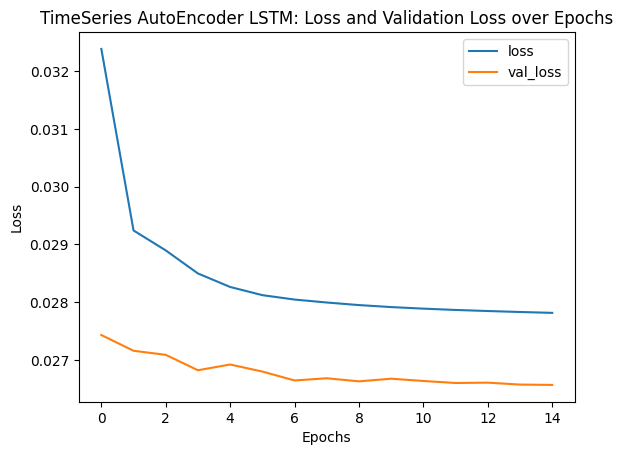

In [160]:
history = model.fit(X_train, X_train, epochs=15, batch_size=X_train.shape[1], validation_data=(X_test, X_test), verbose=1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("TimeSeries AutoEncoder LSTM: Loss and Validation Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Predicts the values using the testing data

In [167]:
yhat = model.predict(X_test, verbose=0)

In [181]:
X_test
X_test[0].sum(), yhat[0].sum()
X_train.shape[1]
max(plot[1])

1.1573436969567885

Calculates the anomoly score for each input in the testing data by the difference of the sum of the features and the predicted y value. Then established the anomoly cutoff based on the percentage of malicious datapoints in our sample and plots a histogram. This usually is done experimentally, but since we know the percentage of malicious in our dataset, we are able to evaluate the perfomance of the model.

Threshold: 0.4164280786209767


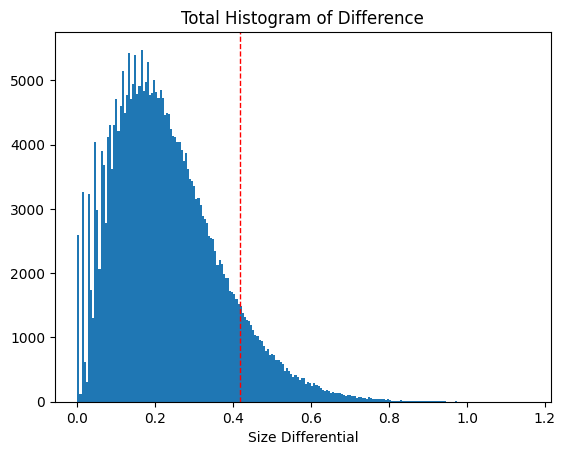

In [178]:
diff = [abs(x.sum() - y.sum())/X_test.shape[1] for x, y in zip(X_test, yhat)]
plot = plt.hist(diff, bins='auto')
plt.title("Total Histogram of Difference")
plt.xlabel("Size Differential")

i, total, percent = 0,0,0
while percent < .9:
    total+=plot[0][i]
    percent =  total / X_test.shape[0]
    i+=1
print("Threshold:", plot[1][i])
plt.axvline(plot[1][i], color='red', linestyle='dashed', linewidth=1)
plt.show()

Seperates the anomolies from the regular data using the threshold value

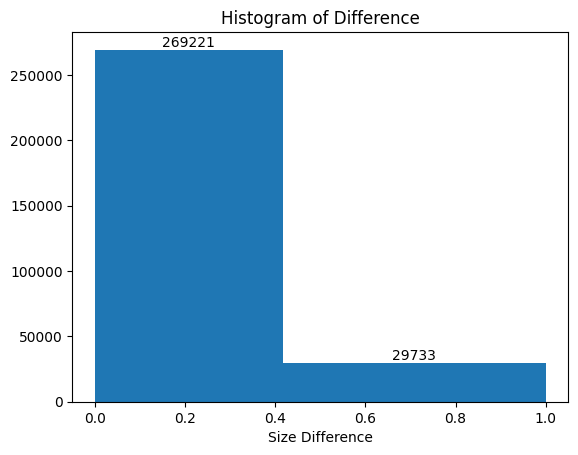

In [180]:
counts, edges, bars = plt.hist(diff,bins=[0,plot[1][i],1])
size_bar = plt.bar_label(bars)
plt.title("Histogram of Difference")
plt.xlabel("Size Difference")
plt.show()